In [32]:

import cv2
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt

print(cv2.__version__)

4.12.0


In [104]:
import os

home_dir = os.getenv('HOME')
img_dir = os.path.join(home_dir, "work/human_segmentation/images/")
img_names = ['image_1', 'image_2', 'image_3','image_4','image_5' ,'image_6','image_7','image_8']
#이미지를 리스트로 변환해 호출시 유동적으로 이용할 수 있게 생성

images = []
for name in img_names :
  path = os.path.join(img_dir, name + '.jpg')
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  images.append(img)  # RGB 변환

sand_img = cv2.imread(os.path.join(home_dir, "work/human_segmentation/images/sand.jpg"))


In [39]:
model = deeplabv3_resnet101(pretrained=True).eval()

transform = T.Compose([
    T.ToPILImage(),
    T.Resize((520, 520)),  # 모델 입력 크기
    T.ToTensor(),
])


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [105]:
def img_blur(img):

    input_tensor = transform(img).unsqueeze(0)

    with torch.no_grad():
        output = model(input_tensor)["out"][0]
        output_predictions = output.argmax(0).byte().cpu().numpy()

    print(f"추론 마스크 크기 (Before Resize): {output_predictions.shape}")

    output_predictions_resized = cv2.resize(output_predictions, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

    unique_classes = np.unique(output_predictions_resized)
    print(f"예측된 클래스 ID: {unique_classes}")

    target_class_id = unique_classes[-1]

    seg_map = (output_predictions_resized == target_class_id)
    img_mask = seg_map.astype(np.uint8) * 255

    plt.imshow(img_mask, cmap='gray')
    plt.show()

In [108]:
def img_blur(img):

    input_tensor = transform(img).unsqueeze(0)

    with torch.no_grad():
     output = model(input_tensor)["out"][0]
     output_predictions = output.argmax(0).byte().cpu().numpy()
     output_predictions_resized = cv2.resize(output_predictions, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

    seg_map = (output_predictions_resized == 15) # 클래스 ID 15 (사람)
    cat_seg_map = (output_predictions_resized == 8)  # 클래스 ID 8 (고양이)
    combined_mask = (seg_map | cat_seg_map) #사람과 고양이를합쳐서 comdined_mask를 생성
    img_mask = combined_mask.astype(np.uint8) * 255
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

    img_orig_blur = cv2.blur(img, (13, 13)) #블러필터 사이즈 13,13
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)

    img_concat = np.where(img_mask_color==255, img, img_bg_blur)
    img_show = cv2.addWeighted(img, 0.6, color_mask, 0.6, 0.0)
    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    plt.imshow(img_concat)
    unique_classes = np.unique(output_predictions_resized)
    print(f"예측된 클래스 ID: {unique_classes}")
    plt.show()


In [98]:
def seg(img):
  #cat segmentation
  input_tensor = transform(img).unsqueeze(0)

  with torch.no_grad():
      output = model(input_tensor)["out"][0]
      output_predictions = output.argmax(0).byte().cpu().numpy()

  print(f"추론 마스크 크기 (Before Resize): {output_predictions.shape}")

  output_predictions_resized = cv2.resize(output_predictions, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

  unique_classes = np.unique(output_predictions_resized)
  print(f"예측된 클래스 ID: {unique_classes}")

  target_class_id = 8

  seg_map = (output_predictions_resized == target_class_id)
  img_mask = seg_map.astype(np.uint8) * 255

  return(img_mask)


예측된 클래스 ID: [ 0 15]


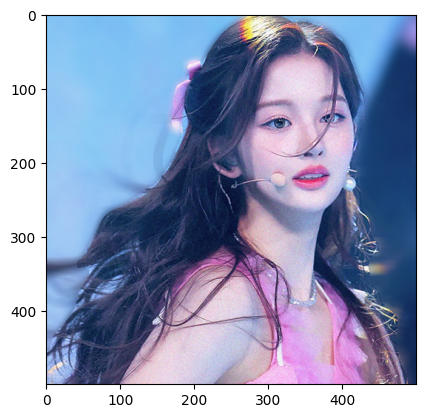

예측된 클래스 ID: [ 0 15]


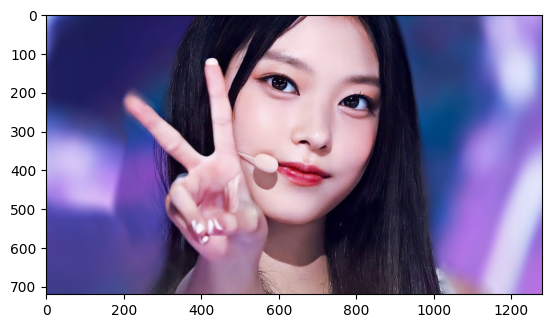

예측된 클래스 ID: [ 0 15]


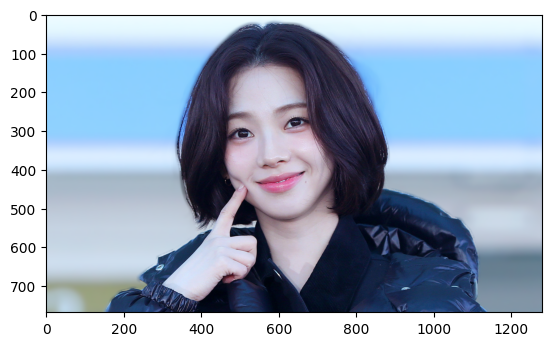

예측된 클래스 ID: [ 0 14 15]


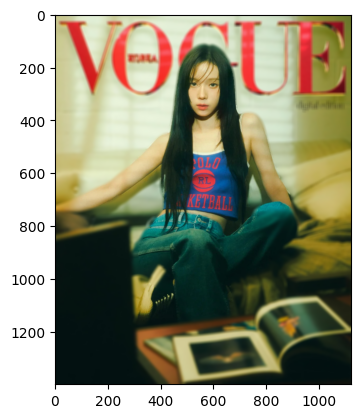

예측된 클래스 ID: [ 0  8 15]


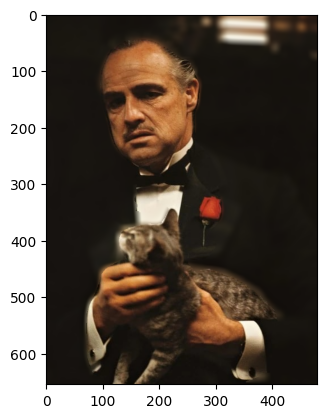

예측된 클래스 ID: [ 0 15]


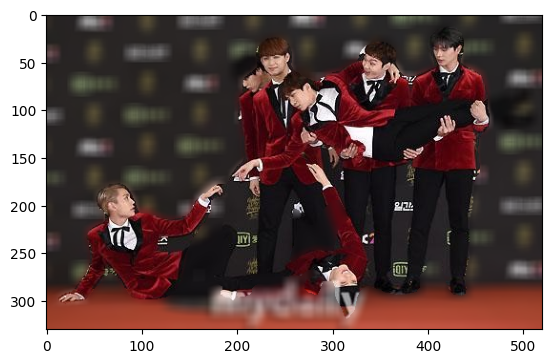

예측된 클래스 ID: [0 8]


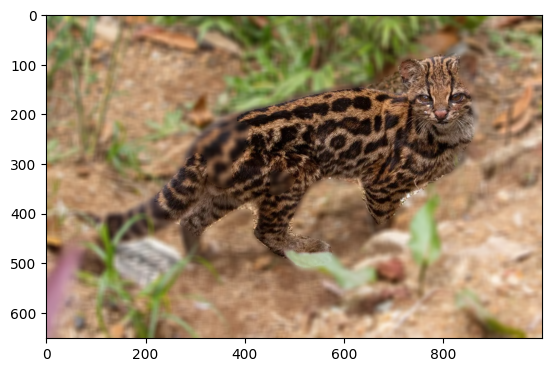

예측된 클래스 ID: [ 0  8 15]


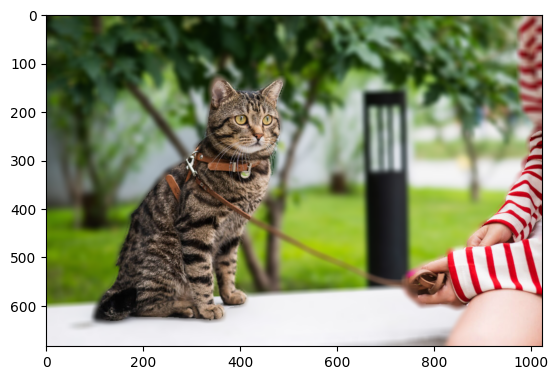

In [109]:
for img in images :
  img_blur(img)

추론 마스크 크기 (Before Resize): (520, 520)
예측된 클래스 ID: [ 0  8 15]


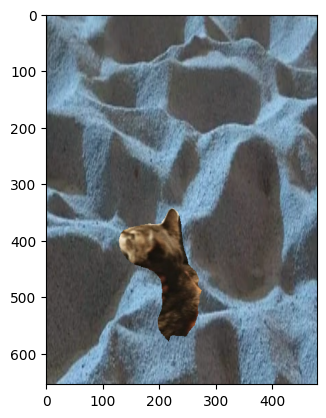

추론 마스크 크기 (Before Resize): (520, 520)
예측된 클래스 ID: [ 0  8 15]


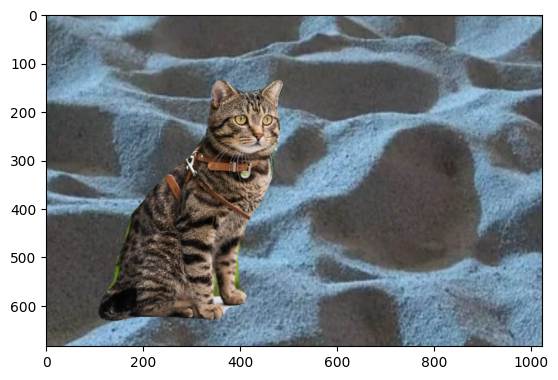

추론 마스크 크기 (Before Resize): (520, 520)
예측된 클래스 ID: [0 8]


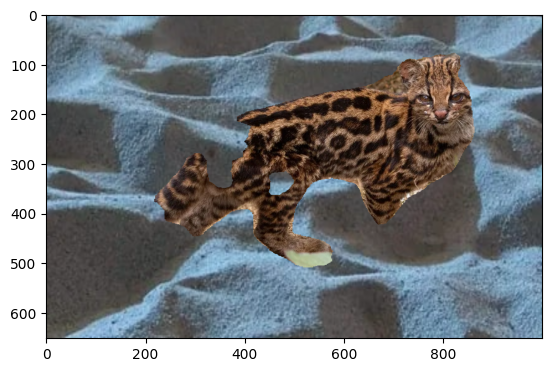

In [92]:
# 배경을 고양이 이미지 크기에 맞춤
for img in images :
  sand_img_resized = cv2.resize(sand_img, (img.shape[1], img.shape[0]))

  # 고양이 부분만 남기고 배경 적용
  img_mask_color = cv2.cvtColor(seg(img), cv2.COLOR_GRAY2BGR)  # 3채널 변환
  result_img = np.where(img_mask_color == 255, img, sand_img_resized)  # 마스크 기반 합성

  plt.imshow(result_img)
  plt.show()

배경과 대상이 확실히 분리되는 경우 segmentation이 잘 되지만
배경과 색이 비슷할 경우 그렇지 못한 경우가 많다.



###현재까지 발견한 문제점
##1. 객체 구분문제
cv에서는 밝기 = 정보이다  
하지만 어두운곳에서는 이러한 정보가 너무 적어 모델이 판단하기 위한 정보가 부족하다.

이러한 경우에는 밝기를 올려주면 일부 해결할 수 있을것으로 보인다.

##2. 유사 색상 문제
객체과 근처 배경이 유사한 색상, 패턴을 가진 경우 구분하기 힘들어하는 모습을 확인할 수 있다.  
이러한 경우 모델 학습과정에서 필터를 잘 선택해 외곽선 혹은 패턴인식에 힘을주면 괜찮아질것이라고 생각한다.

##3. 비정상적인 형태()